# Roaches cross-validation demo

This case study is a PyMC3 port of the same demo in [/avehtari/modelselection_tutorial](https://github.com/avehtari/modelselection_tutorial). 

I am slowly porting all example to https://github.com/junpenglao/modelselection_tutorial - PR welcome!

This example comes from Chapter 8.3 of [Gelman and Hill (2007)](http://www.stat.columbia.edu/~gelman/arm/) and the introduction text is from [Estimating Generalized Linear Models for Count Data with rstanarm](https://cran.r-project.org/web/packages/rstanarm/vignettes/count.html) by Jonah Gabry and Ben Goodrich.

We want to make inferences about the efficacy of a certain pest management system at reducing the number of roaches in urban apartments. Here is how Gelman and Hill describe the experiment (pg. 161):

> the treatment and control were applied to 160 and 104 apartments, respectively, and the outcome measurement $y_i$ in each apartment $i$ was the number of roaches caught in a set of traps. Different apartments had traps for different numbers of days

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
print('Runing on PyMC3 v{}'.format(pm.__version__))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Runing on PyMC3 v3.4.1


In [2]:
roaches = pd.read_csv('roaches.csv', sep=' ')
roaches.head()

,y,roach1,treatment,senior,exposure2
0,153,3.0800,1,0,0.800000
1,127,3.3125,1,0,0.600000
2,7,0.0167,1,0,1.000000
3,7,0.0300,1,0,1.000000
4,0,0.0200,1,0,1.142857


In addition to an intercept, the regression predictors for the model are the pre-treatment number of roaches `roach1`, the treatment indicator `treatment`, and a variable indicating whether the apartment is in a building restricted to elderly residents `senior`. Because the number of days for which the roach traps were used is not the same for all apartments in the sample, we include it as an `exposure2` by adding `ln(ui))` to the linear predictor $\eta_i$.

In [3]:
scale = np.std(roaches[['roach1', 'treatment', 'senior']])

In [4]:
2.5/scale.values

array([3.32808818, 5.10970805, 5.42825964])

In [3]:
with pm.Model() as glmp:
    pm.glm.GLM.from_formula(
        'y ~ roach1 + treatment + senior', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=pm.glm.families.Poisson(),
        offset=np.log(roaches['exposure2'].values)
              )
    trace0 = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, senior, treatment, roach1, Intercept]
  9%|▉         | 185/2000 [00:07<00:46, 39.23it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '11398' (I am process '11399')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/jlao/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir
 10%|▉         | 190/2000 [00:07<00:53, 34.12it/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '11398' (I am process '11400')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/jlao/.theano/compiledir_Darwin-17.5.0-x86_64-i386-64bit-i386-3.5.1-64/lock_dir
 54%|█████▍    | 1085/2000 [00:17<00:10, 85.97it/s] INFO (theano.gof.compilelock): Waiting for existing lock by process '11399' (I am process '11400')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/

In [4]:
pm.summary(trace0)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,3.089224,0.021431,0.000368,3.047760,3.129412,3449.042815,1.000245
roach1,0.698183,0.009050,0.000139,0.680633,0.716129,3822.584797,1.000455
treatment,-0.516931,0.024829,0.000338,-0.565478,-0.468457,4167.010403,0.999861
senior,-0.379701,0.033367,0.000502,-0.441067,-0.309995,4135.759272,0.999757
mu,63.992559,712.309746,13.349206,0.008430,125.683615,2784.863987,0.999921


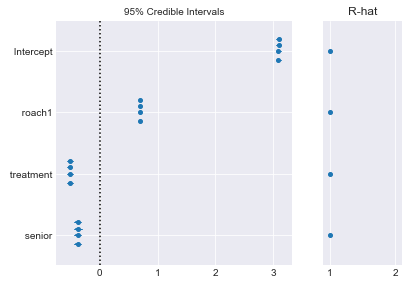

In [5]:
pm.forestplot(trace0, 
              varnames=['Intercept', 'roach1', 'treatment', 'senior']);

The loo function in PyMC3 doesnt provides all the information necessary, use new functions instead (PR welcome to add this and [related new features](http://mc-stan.org/loo/articles/index.html) in `loo` to PyMC3):

In [6]:
import loo
df_loo, pointwise = loo.loo(trace0, model=glmp)

Computed from 4000 by 262 log-likelihood matrix


In [7]:
df_loo

,Estimate,SE
elpd_loo,-6241.293410,724.397418
p_loo,291.045926,73.161639
looic,12482.586820,1448.794835


Here the table shows the expected log predictive density (`elpd_loo`) and the estimated effective number of parameters (`p_loo`). If we had a well-specified model we would expect the p_loo to be smaller than or similar to the total number of parameters in the model. For more see [here](http://discourse.mc-stan.org/t/a-quick-note-what-i-infer-from-p-loo-and-pareto-k-values/3446?u=junpenglao).

In [8]:
df_k = loo.ks_summary(pointwise['ks'])

Pareto k diagnostic values:
             Count        Pct           _
(-Inf, 0.5]    238  90.839695      (good)
 (0.5, 0.7]      6   2.290076        (ok)
   (0.7, 1]      7   2.671756       (bad)
   (1, Inf)     11   4.198473  (very bad)


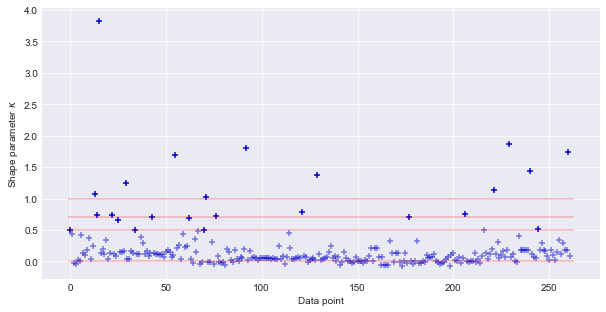

In [9]:
loo.plot_khat(pointwise['ks']);

In [10]:
ppc_ = pm.sample_ppc(trace0, 500, model=glmp)

100%|██████████| 500/500 [00:01<00:00, 326.39it/s]


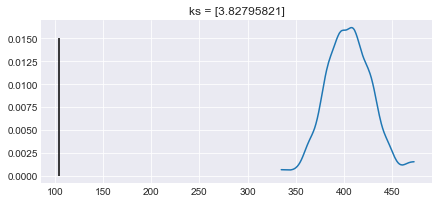

In [11]:
index = pointwise['ks']==np.max(pointwise['ks'])
ppc_obs = ppc_['y'][:, index]
obs = roaches['y'][index]
_, ax = plt.subplots(1, 1, figsize=(7, 3))
pm.kdeplot(ppc_obs, ax=ax)
ax.vlines(obs, 0, .015)
ax.set_title('ks = {}'.format(pointwise['ks'][index]));

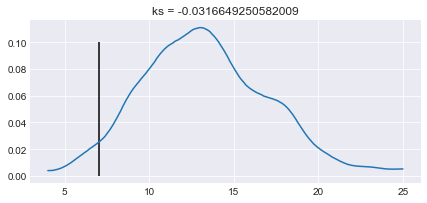

In [12]:
index = 2
ppc_obs = ppc_['y'][:, index]
obs = roaches['y'][index]
_, ax = plt.subplots(1, 1, figsize=(7, 3))
pm.kdeplot(ppc_obs, ax=ax)
ax.vlines(obs, 0, .1)
ax.set_title('ks = {}'.format(pointwise['ks'][index]));

There are several observations which are highly influential, which indicates potential model misspecification.

Before looking in more detail where the problem is or fixing it, let’s check what would cross-validation say about relevance of covariates.

We form 3 models by dropping each of the covariates out.

In [13]:
with pm.Model() as glm1p:
    pm.glm.GLM.from_formula(
        'y ~ treatment + senior', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=pm.glm.families.Poisson(),
        offset=np.log(roaches['exposure2'].values)
              )
    trace1 = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, senior, treatment, Intercept]
100%|██████████| 2000/2000 [00:41<00:00, 48.00it/s] 


In [14]:
with pm.Model() as glm2p:
    pm.glm.GLM.from_formula(
        'y ~ roach1 + senior', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=pm.glm.families.Poisson(),
        offset=np.log(roaches['exposure2'].values)
              )
    trace2 = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, senior, roach1, Intercept]
100%|██████████| 2000/2000 [00:35<00:00, 56.63it/s] 


In [15]:
with pm.Model() as glm3p:
    pm.glm.GLM.from_formula(
        'y ~ roach1 + treatment', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=pm.glm.families.Poisson(),
        offset=np.log(roaches['exposure2'].values)
              )
    trace3 = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, treatment, roach1, Intercept]
100%|██████████| 2000/2000 [01:16<00:00, 78.27it/s] 


Although khats were very large we can make a quick test with PSIS-LOO (if the comparison would say there is difference, then PSIS-LOO couldn’t be trusted and PSIS-LOO+ or k-fold-CV woul be needed).

In [16]:
df_loo1, pointwise1 = loo.loo(trace1, model=glm1p)
df_loo1

Computed from 4000 by 262 log-likelihood matrix


,Estimate,SE
elpd_loo,-8464.366167,898.296729
p_loo,265.134379,49.584713
looic,16928.732335,1796.593458


In [18]:
df_k = loo.ks_summary(pointwise1['ks'])

Pareto k diagnostic values:
             Count        Pct           _
(-Inf, 0.5]    241  91.984733      (good)
 (0.5, 0.7]      9   3.435115        (ok)
   (0.7, 1]      6   2.290076       (bad)
   (1, Inf)      6   2.290076  (very bad)


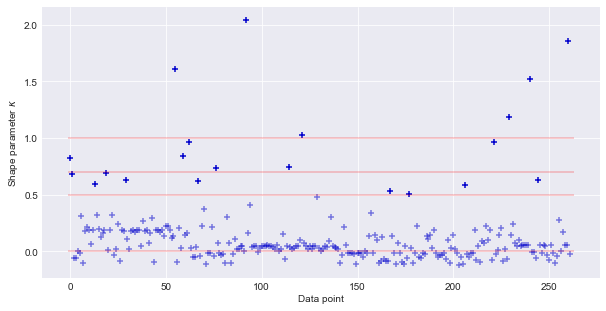

In [19]:
loo.plot_khat(pointwise1['ks']);

In [20]:
df_loo2, pointwise2 = loo.loo(trace2, model=glm2p)
df_loo2

Computed from 4000 by 262 log-likelihood matrix


,Estimate,SE
elpd_loo,-6426.021214,795.225371
p_loo,221.060635,54.517929
looic,12852.042429,1590.450742


In [21]:
df_k = loo.ks_summary(pointwise2['ks'])

Pareto k diagnostic values:
             Count        Pct           _
(-Inf, 0.5]    248  94.656489      (good)
 (0.5, 0.7]      3   1.145038        (ok)
   (0.7, 1]      2   0.763359       (bad)
   (1, Inf)      9   3.435115  (very bad)


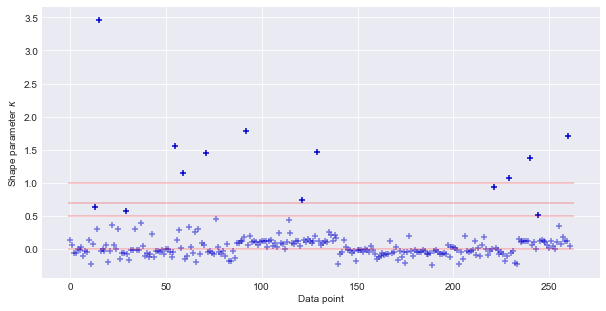

In [22]:
loo.plot_khat(pointwise2['ks']);

In [23]:
df_loo3, pointwise3 = loo.loo(trace3, model=glm3p)
df_loo3

Computed from 4000 by 262 log-likelihood matrix


,Estimate,SE
elpd_loo,-6284.261045,705.975501
p_loo,237.166481,70.392473
looic,12568.522089,1411.951002


Pareto k diagnostic values:
             Count        Pct           _
(-Inf, 0.5]    248  94.656489      (good)
 (0.5, 0.7]      3   1.145038        (ok)
   (0.7, 1]      2   0.763359       (bad)
   (1, Inf)      9   3.435115  (very bad)


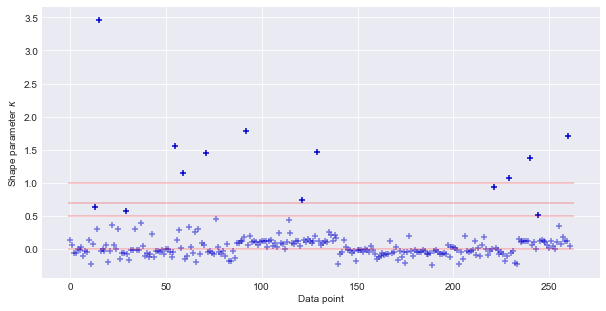

In [24]:
df_k = loo.ks_summary(pointwise2['ks'])
loo.plot_khat(pointwise2['ks']);

In [25]:
comp1 = loo.compare([pointwise1, pointwise])
comp1.round(1)

,elpd_diff,se
m1-m0,2223.1,612.2


In [26]:
comp2 = loo.compare([pointwise2, pointwise])
comp2.round(1)

,elpd_diff,se
m1-m0,184.7,191.9


In [27]:
comp3 = loo.compare([pointwise3, pointwise])
comp3.round(1)

,elpd_diff,se
m1-m0,43.0,109.6


Based on this the roaches covariate would be relevant, but although dropping treatment or senior covariate will make a large chnage to elpd, the uncertainty is also large and cross-validation states that these covariates are not necessarily relevant! The posterior marginals are conditional on the model, but cross-validation is more cautios by not using any model for the future data distribution.

It’s also good to remember that in addition of cross-validation, the posterior predictive checks can often detect problems and also provide more information about the reason. Here we test the proportion of zeros predicted by the model and compare them to the observed number of zeros.

100%|██████████| 500/500 [00:00<00:00, 508.84it/s]


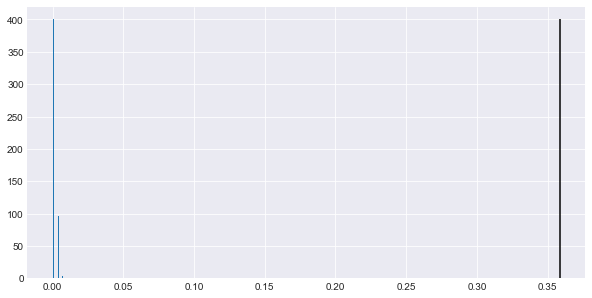

In [28]:
ppc = pm.sample_ppc(trace0, samples=500, model=glmp)

_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist((ppc['y']==0).mean(axis=1))
ax.vlines((roaches['y']==0).mean(), 0, 400);



Next we change the Poisson model to a more robust negative binomial model

In [29]:
neg_binom_fam = pm.glm.families.NegativeBinomial(
    priors = {'alpha': pm.Exponential.dist(lam=1)})
with pm.Model() as glmnb:
    pm.glm.GLM.from_formula(
        'y ~ roach1 + treatment + senior', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=neg_binom_fam,
        offset=np.log(roaches['exposure2'].values)
              )
    trace0nb = pm.sample(1000, tune=1000, cores=4)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, mu, senior, treatment, roach1, Intercept]
100%|██████████| 2000/2000 [00:53<00:00, 37.12it/s]


In [31]:
pm.summary(trace0nb)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,2.842492,0.232299,0.003879,2.385497,3.287487,3178.301642,0.999975
roach1,1.316550,0.250336,0.003917,0.854963,1.832515,4051.304130,0.999741
treatment,-0.773506,0.250962,0.004002,-1.245398,-0.254810,4245.326547,1.000227
senior,-0.330223,0.268025,0.004061,-0.831523,0.200886,4535.712730,0.999517
mu,66.243194,868.993744,14.452943,0.001081,143.761744,3740.171912,1.000881
alpha,0.272115,0.026026,0.000355,0.220076,0.321820,4983.582560,0.999863


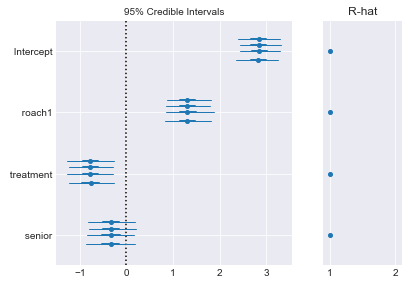

In [32]:
pm.forestplot(trace0nb, 
              varnames=['Intercept', 'roach1', 'treatment', 'senior']);


Treatment effect is much closer to zero, and senior effect has lot of probability mass on both sides of 0. So it matters, which model we use.

Plot also here paired marginals.

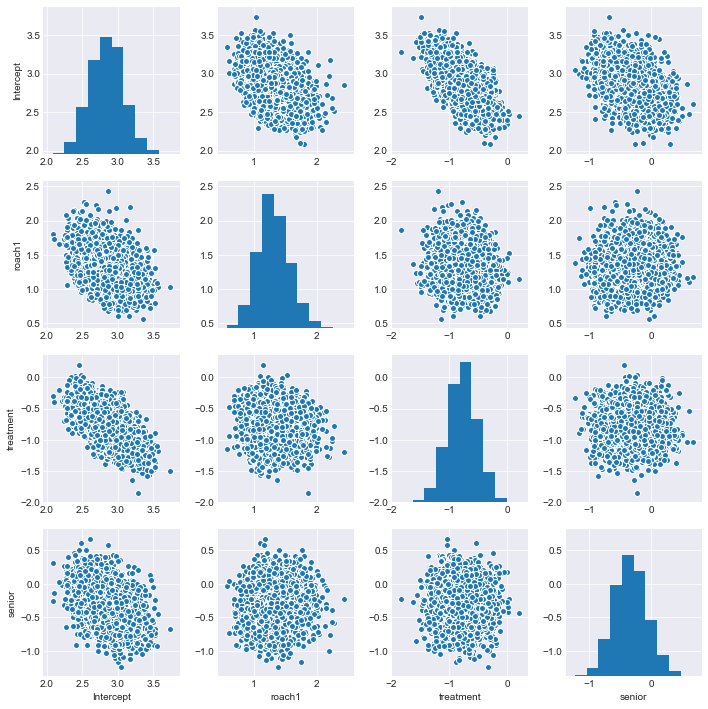

In [33]:
import seaborn as sns
tracedf0 = pm.trace_to_dataframe(trace0nb,
                                 varnames=['Intercept', 'roach1', 'treatment', 'senior'])
sns.pairplot(tracedf0);

There are some posterior correlations, but not something which would change our conclusions.

Let’s check Pareto khat diagnostics.

In [34]:
loo_nb, pw_nb = loo.loo(trace0nb, model=glmnb)
loo_nb

Computed from 4000 by 262 log-likelihood matrix


,Estimate,SE
elpd_loo,-895.701937,37.689451
p_loo,6.744645,2.616635
looic,1791.403875,75.378901


Pareto k diagnostic values:
             Count        Pct           _
(-Inf, 0.5]    260  99.236641      (good)
 (0.5, 0.7]      1   0.381679        (ok)
   (0.7, 1]      1   0.381679       (bad)
   (1, Inf)      0   0.000000  (very bad)


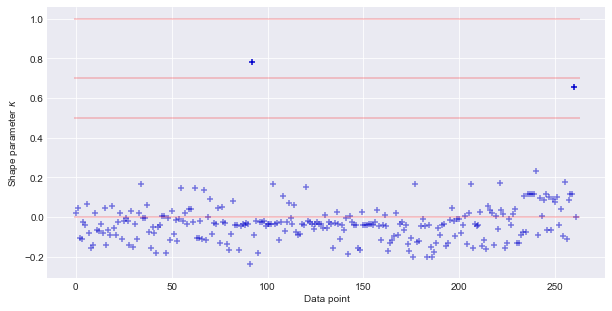

In [36]:
df_nb = loo.ks_summary(pw_nb['ks'])
loo.plot_khat(pw_nb['ks']);


We can also compare Poisson and negative-Binomial.

In [37]:
compnew = loo.compare([pw_nb, pointwise])
compnew.round(1)

,elpd_diff,se
m1-m0,-5345.6,705.7


Negative-Binomial model is clearly better than Poisson.

As Poisson is a special case of negative-Binomial, we could have also seen that Poisson is likely by lookig at the posterior of the over-dispersion parameter (which gets very small values).

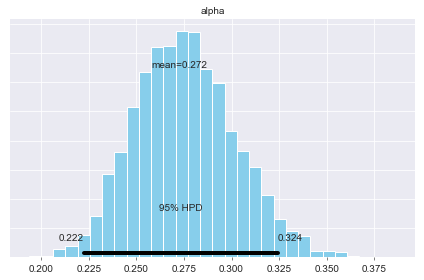

In [29]:
pm.plot_posterior(trace0nb, varnames=['alpha']);



We next use posterior predictive checking to check that the improved model can also predict the proportion of zeros well.

100%|██████████| 500/500 [00:00<00:00, 675.01it/s]


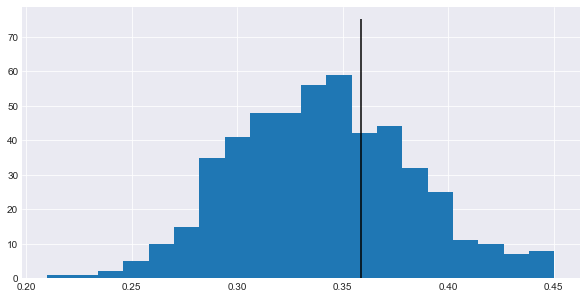

In [30]:
ppc = pm.sample_ppc(trace0nb, samples=500, model=glmnb)

_, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.hist((ppc['y']==0).mean(axis=1), 20)
ax.vlines((roaches['y']==0).mean(), 0, 75);

result looks much better than for the Poisson model.

Let’s finally check cross-validation model comparison that it agrees on relevance of covariates.

In [31]:
with pm.Model() as glm1nb:
    pm.glm.GLM.from_formula(
        'y ~ treatment + senior', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=neg_binom_fam,
        offset=np.log(roaches['exposure2'].values)
              )
    trace1nb = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha, senior, treatment, Intercept]
100%|██████████| 2000/2000 [00:11<00:00, 174.97it/s]


In [32]:
with pm.Model() as glm2nb:
    pm.glm.GLM.from_formula(
        'y ~ roach1 + senior', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=neg_binom_fam,
        offset=np.log(roaches['exposure2'].values)
              )
    trace2nb = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha, senior, roach1, Intercept]
100%|██████████| 2000/2000 [00:16<00:00, 119.51it/s]


In [33]:
with pm.Model() as glm3nb:
    pm.glm.GLM.from_formula(
        'y ~ roach1 + treatment', data=roaches,
        priors=dict(Intercept=pm.Normal.dist(mu=0, sd=5),
                    roach1=pm.Normal.dist(mu=0, sd=2.5),
                    treatment=pm.Normal.dist(mu=0, sd=2.5),
                    senior=pm.Normal.dist(mu=0, sd=2.5)),
        family=neg_binom_fam,
        offset=np.log(roaches['exposure2'].values)
              )
    trace3nb = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, alpha, treatment, roach1, Intercept]
100%|██████████| 2000/2000 [00:12<00:00, 157.68it/s]


In [34]:
loo_nb1, pw_nb1 = loo.loo(trace1nb, model=glm1nb)
comp1_ = loo.compare([pw_nb1, pw_nb])
comp1_.round(1)

Computed from 4000 by 262 log-likelihood matrix


,elpd_diff,se
m1-m0,21.4,6.0


In [35]:
loo_nb2, pw_nb2 = loo.loo(trace2nb, model=glm2nb)
comp2_ = loo.compare([pw_nb2, pw_nb])
comp2_.round(1)

Computed from 4000 by 262 log-likelihood matrix


,elpd_diff,se
m1-m0,3.5,4.3


In [36]:
loo_nb3, pw_nb3 = loo.loo(trace3nb, model=glm3nb)
comp3_ = loo.compare([pw_nb3, pw_nb])
comp3_.round(1)

Computed from 4000 by 262 log-likelihood matrix


,elpd_diff,se
m1-m0,-1.4,2.8


Roaches1 has clear effect. Treatment effect was visible in posterior, but as discussed in betablockers demo, cross-validation is not good for detecting weak effects. Based on cross-validation senior effect is also not relevant.

Conclusion from the analysis would be then that, treatment is likely to help, but it’s difficult to predict the number of roaches given treatment or not.